# Effective Stiffness of Fiber Composite



## Introduction

This example demonstrates the use of the homogenization model from PyMKS on a set of fiber-like structures.  These structures are simulated to emulate fiber-reinforced polymer samples.  For a summary of homogenization theory and its use with effective stiffness properties please see the [Effective Siffness example](http://materialsinnovation.github.io/pymks/rst/stress_homogenization_2D.html). This example will first generate a series of random microstructures with various fiber lengths and volume fraction.  The ability to vary the volume fraction is a new functionality of this example.  Then the generated stuctures will be used to calibrate and test the model based on simulated effective stress values.  Finally we will show that the simulated response compare favorably with those generated by the model.  

## Generating Structures

In [55]:
# NBVAL_IGNORE_OUTPUT

from __future__ import print_function
import pymks

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from pymks.fmks.correlations import auto_correlation
from sklearn.decomposition import PCA
import pandas



Below are definitions for parameters used to create the microstructures.  `n_samples` determines how many microstructures of a particular volume fraction to create.  `size` determines the number of pixels to include in the microstructure.  We define the material properties used in the finite element simulation with `elastic_modulus`, `poissons_ratio` and `macro_strain`.  `n_phases` and `grain_size` determine the physical characteristics of the microstructure.  We use a high aspect ratio of grain shape to create our microstructures to simulate fiber-like structures.  The `v_frac` variable determines the fraction of each phase.  The sum of the volume fractions must be equal to 1.  The `percent_variance` variable introduces variation into the volume fraction up to the specified percentage.

In [2]:
sample_size = 100
n_samples = 4 * [sample_size]
size = (101, 101)
elastic_modulus = (1.3, 75)
poissons_ratio = (0.42, .22)
macro_strain = 0.001
n_phases = 2
grain_size = [(40, 2), (10, 2), (2, 40), (2, 10)]
v_frac = [(0.7, 0.3), (0.6, 0.4), (0.3, 0.7), (0.4, 0.6)]
percent_variance = 0.1


Below we create the microstructures and generate their responses using the `make_elastic_stress_random` function from PyMKS.  Four datasets are used to generate the four different volume fractions simulated.  Then the datasets are combined into one variable. The volume fractions are listed in the variable `v_frac`.  Variation around the specified volume fraction is obtained by varying `percent_variance`.  The variation is randomly generated according to a uniform distribution around the specified volume fraction.

In [3]:
# NBVAL_IGNORE_OUTPUT

from pymks.datasets import make_elastic_stress_random


dataset, stresses = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size,
                                                 elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio,
                                                 macro_strain=macro_strain, volume_fraction=v_frac,
                                                 percent_variance=percent_variance)


/nix/store/pjs24p0c3qjmbqb91ilqxdqlppkah84h-python3.7-toolz-0.9.0/lib/python3.7/site-packages/toolz/itertoolz.py:723: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  yield prev[:prev.index(no_pad)]


Below are a few microstructres to look at how the fiber length, orientation and volume fraction are varied.  

In [4]:
examples = dataset[::sample_size]

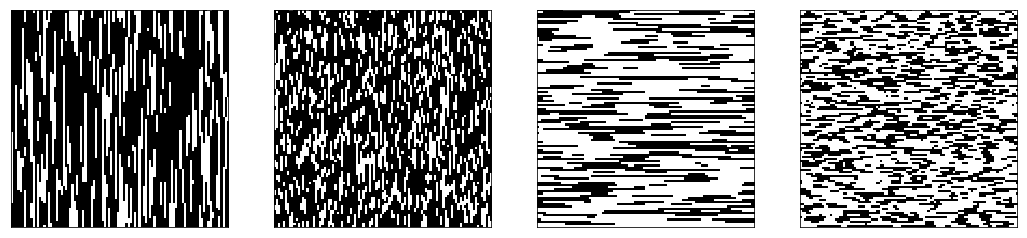

In [5]:
fig, axs = plt.subplots(1, examples.shape[0], figsize=(4 * examples.shape[0], 4))
fig.subplots_adjust(right=1)

def plot_binary(arrs,ax):
    ax.set_xticks(())
    ax.set_yticks(())   
    return ax.imshow(arrs,cmap='gray')

for x in range(examples.shape[0]):
    plot_binary(examples[x],axs[x])

## Creating the Model

Next we create the the homogenization pipeline. The sklearn pipelines assemble multiple steps together that can be cross-validated together (with different parameters). The Pipeline below (`bl`)  takes in microstructures, discritizes the microstructures and runs two-point statistics to get a statistical representation of the microstructures.  An explanation of the use of two-point statistics can be found in the [Checkerboard Microstructure Example](http://materialsinnovation.github.io/pymks/rst/checker_board.html).  Then the model uses PCA and regression models to create a linkage between the calcualted properties and structures.  
Here we simply initiate the homogenization pipeline.  

In [6]:
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointcorrelation,FlattenTransformer

bl = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointcorrelation(periodic_boundary=True, cutoff=25,correlations=[(1,1),(0,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA()),
    ('poly', PolynomialFeatures()),
    ('connector', LinearRegression())
])

Split the data into testing and training segments to see if the model accurately predicts the effective stress. 


In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, stress_train, stress_test = train_test_split(
    dataset, stresses, test_size=0.2, random_state=3)

Use sklearn's GridSearchCV to optimize the `n_components` and `degree` hyper-parameters for the model. Let's search over the range of 1st order to 3rd order degree polynomials and 2 to 7 principal components.

In [78]:
from sklearn.model_selection import GridSearchCV

params_to_tune = {'reducer__n_components': np.arange(2, 7),'poly__degree': np.arange(1, 4)}

gs = GridSearchCV(bl, cv=3, param_grid=params_to_tune, iid=True, return_train_score=True).fit(data_train, stress_train)

Let's take a look at the results.

In [79]:
print('Order of Polynomial',gs.best_params_.get('poly__degree'))
print('Number of Components', gs.best_params_.get('reducer__n_components'))
print('R-squared Value', np.allclose(gs.score(data_test, stress_test), 0.9985, rtol=1e-1))

Order of Polynomial 2
Number of Components 5
R-squared Value True


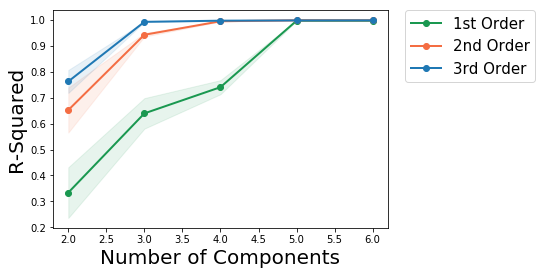

In [80]:
from toolz.curried import groupby, get, pipe, valmap, merge_with, merge, valmap, pluck
from toolz.curried import map as map_
from pymks.fmks.func import sequence


def compute(data):
    """Compute the component, error and standard deviation arrays from a grouped
    grid score.
    """
    pluck_ = lambda x: list(pluck(x, data))
    return dict(
        std_dev=pluck_('std_test_score'),
        mean=np.array(pluck_('mean_test_score')),
        x=pluck_('param_reducer__n_components')
    )

def munge(data, plot_data):
    """Compute the data for plotting from the grid scores
    """
    return pipe(
        data,
        groupby(lambda x: x['params']['poly__degree']),
        valmap(compute),
        lambda x: merge_with(merge, plot_data, x)
    )

def plot_line(x, mean, std_dev, color, label):
    plt.fill_between(x, mean - std_dev, mean + std_dev, alpha=0.1, color=color)
    plt.plot(x, mean, 'o-', color=color, label=label, linewidth=2)
    

def plot(grid_scores, plot_data):
    valmap(lambda x: plot_line(**x), munge(grid_scores, plot_data))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    plt.ticklabel_format(style='sci', axis='y')
    plt.ylabel('R-Squared', fontsize=20)
    plt.xlabel('Number of Components', fontsize=20)
    plt.show()
    
plot(
    pandas.DataFrame(gs.cv_results_).to_dict('records'),
    {
        1: dict(label='1st Order', color='#1a9850'),
        2: dict(label='2nd Order', color='#f46d43'),
        3: dict(label='3rd Order', color='#1f78b4')
    }
)

Our best model was found to have `degree` equal to 2 and `n_components` equal to 5. Let's go ahead and use it.

In [81]:
model = gs.best_estimator_

### Structures in PCA space

Now we want to draw how the samples are spread out in PCA space and look at how the testing and training data line up. To do that we initiate a new pipeline (`PCA_pipeline`) that will perform discretization, 2-point correlation representation, and dimensionality reduction on microstructures.

In [73]:
stress_predict = model.predict(data_test)

In [74]:
PCA_pipeline = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointcorrelation(periodic_boundary=True, cutoff=25,correlations=[(1,1),(0,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

Then we apply `PCA_pipeline` to the training dataset and testing dataset to obtain their principle component values

Let's visualize the dimensionally reduced microstructure information in the 3D plot.

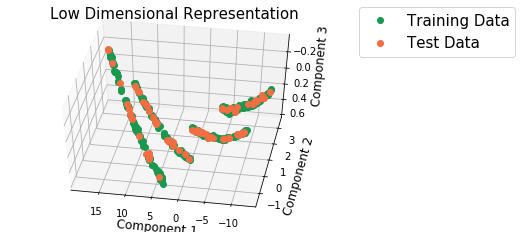

In [75]:
def plot(trained_pca_scores, test_pca_scores):
    
    # required to change Matplotlib context to get 3D working
    # although Axes3D is never used
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    ax.set_zlabel('Component 3', fontsize=12)
    ax.plot(*trained_pca_scores.T, 'o', label='Training Data', color='#1a9850')
    ax.plot(*test_pca_scores.T, 'o', label='Test Data', color='#f46d43')
    plt.title('Low Dimensional Representation', fontsize=15)
    ax.view_init(-132, 80)
    plt.legend(loc=1, borderaxespad=0., fontsize=15)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2,borderaxespad=0., fontsize=15)
    plt.show()
    
plot(
    PCA_pipeline.fit(data_train).transform(data_train),
    PCA_pipeline.transform(data_test)
)

It looks like there is pretty good agreement between the testing and the training data.  We can also see that the four different fiber sizes are seperated in the PC space.  

### Draw Goodness of fit

Let's see how well the model predicts the structure properties. The calculated properties are plotted against the properties generated by the model. We see a linear relationship with a slope of 1.   

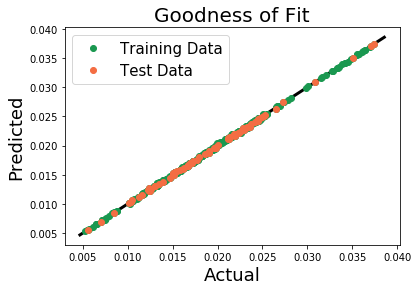

In [76]:
get_ranges = sequence(
    lambda x: np.concatenate(x, axis=-1),
    lambda x: [np.min(x) * 0.9, np.max(x) * 1.03],
    lambda x: (x, x)
)

def plot(fit_data, pred_data):
    plt.plot(*get_ranges([fit_data, pred_data]), linewidth=3, color='#000000')
    out2 = plt.plot(*fit_data, 'o', color='#1a9850', label='Training Data')
    out1 = plt.plot(*pred_data, 'o', color='#f46d43', label='Test Data')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    plt.show()
    
plot(
    np.array([stresses, model.predict(dataset)]),
    np.array([stress_test, stress_predict])
)

There is a good correlation between the FE results and those predicted by the linkage.  